<a href="https://colab.research.google.com/github/AleksandraPanfilova/gnomADxSSDraw/blob/main/gnomADxSSDraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture
#@title gnomADxSSDraw
#@markdown Installing the necessary dependencies can take 1-2 minutes.

# packeges that import out of the box
import pandas as pd
import numpy as np
import re
import os
import math
import requests
import subprocess
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import display, HTML

# get biopython
!pip install Bio
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Seq import Seq
from Bio.PDB import PDBParser, PDBIO

# get DSSP
!pip install torch
!pip install pydssp

#!pip install nomkl
# 3D viewer for the output PDB structure
!pip install py3Dmol
import py3Dmol

# get git repos:
# pynoma -- easy gnomAD data request
# SSDraw -- b-factor (in this case) mapping to the secondary structure
main = os.getcwd()
os.makedirs('dependencies', exist_ok = True)
os.chdir('dependencies')
!git clone https://github.com/AleksandraPanfilova/pynoma.git
!pip install ./pynoma
!git clone https://github.com/AleksandraPanfilova/gnomADxSSDraw.git
os.chdir(main)

from pynoma import TranscriptSearch

# DEFINE FUNCTIONS

def download_alphafold_structure(uniprot_id, output_file="AF_struct.pdb"):
    """
    Downloads the AlphaFold2 predicted structure for the given UniProt ID.

    Args:
        uniprot_id (str): The UniProt ID of the protein.
        output_file (str): The name of the output file where
                          the structure will be saved.

    Returns:
        None
    """
    # AlphaFold URL format for fetching PDB files by UniProt ID
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v6.pdb"

    # Send a GET request to the URL
    response = requests.get(url)

    # If the request is successful, save the PDB content to a file
    if response.status_code == 200:
        with open(output_file, "w") as f:
            f.write(response.text)
        print(f"AlphaFold structure for UniProt ID {uniprot_id} saved to {output_file}")
    else:
        print(f"Failed to retrieve structure for UniProt ID {uniprot_id}. Status code: {response.status_code}")

def get_cds_sequence_from_ensembl(transcript_id):
    """
    Retrieves the CDS (coding sequence) corresponding to an Ensembl
     transcript ID using the Ensembl REST API.

    Args:
        transcript_id (str): The Ensembl transcript ID
                            (e.g., 'ENST00000251127').

    Returns:
        str: The CDS sequence as a string,
             or an error message if not found.
    """
    # Ensembl REST API URL for CDS sequence endpoint
    url = f"https://rest.ensembl.org/sequence/id/{transcript_id}?type=cds;content-type=application/json"

    # Send the GET request to Ensembl REST API
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        cds_sequence = data.get("seq", None)

        if cds_sequence:
            return cds_sequence
        else:
            return "CDS sequence not found for this transcript ID."
    else:
        return f"Error: Unable to retrieve data (Status code {response.status_code})"


def get_uniprot_sequence(uniprot_id, fasta_path):
    """
    Retrieves the protein sequence corresponding to a UniProt ID
      using the UniProt API.

    Args:
        uniprot_id (str): The UniProt ID of the protein (e.g., 'P69905').

    Returns:
        str: The protein sequence as a string, or an error
             message if not found.
    """
    # UniProt API URL to fetch the protein sequence in fasta format
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"

    # Send the GET request to UniProt API
    response = requests.get(url)

    if response.status_code == 200:
        fasta_data = response.text
        with open(fasta_path, "w") as f:
            f.write(fasta_data)
        # Extract the sequence from the FASTA format
        # Ignore the header and join the sequence lines
        sequence = ''.join(fasta_data.split('\n')[1:])
        return sequence
    else:
        return f"Error: Unable to retrieve data (Status code {response.status_code})"

def from_pNxN_to_N_X_N(df):
    # Dictionary for reformatting from 3-letter string variant indicator
    # to 1-letter separate columns indicator
    d = {'Cys': 'C', 'Asp': 'D', 'Ser': 'S', 'Gln': 'Q', 'Lys': 'K',
         'Ile': 'I', 'Pro': 'P', 'Thr': 'T', 'Phe': 'F', 'Asn': 'N',
         'Gly': 'G', 'His': 'H', 'Leu': 'L', 'Arg': 'R', 'Trp': 'W',
         'Ala': 'A', 'Val':'V', 'Glu': 'E', 'Tyr': 'Y', 'Met': 'M'}

    # Splitting the variant into 3 pd.Series -- wild type aa, substitution aa (mutation),
    # and residue position
    # Additionaly, 3-letter code is replaced with 1-letter for aa
    df = df.copy()
    wt = df['Consequence'].str.split('.').str[1].str[:3].replace(d)
    sub = df['Consequence'].str.split('.').str[1].str[-3:].replace(d)
    pos = df['Consequence'].str.split('.').str[1].str[3:-3].astype(int)

    # Create new columns from the 3 series above
    df['wt'] = wt
    df['pos'] = pos
    df['sub'] = sub
    #gnomAD_filt['var'] = wt + pos.astype(str) + sub
    df.drop(columns=['Consequence'], inplace=True)

    # Order the dataframe by position and substitution
    df = df.sort_values(by=['pos', 'sub']).reset_index(drop=True)

    return df

def allele_frequency_processing(df):
    # Takes in pynoma-fetched and -processed gnomAD dataframe
    # and gets an allele frequency value per position
    # by summing up all missense variants occuring at the
    # position and deviding it by the highest number
    # of sequenced individuals for a position.

    raw_freq = df.copy()


    # If for any reason gnomAD is giving different sequenced
    # Allele Number for variants at the same position,
    # this makes sure we calculate frequency based on the highest number.
    allele_number_max = df[['pos', 'wt', 'Allele Number']].groupby(['pos', 'wt']).max().reset_index()

    #  Summing up counts for all variants at the position.
    df = df[['pos', 'wt', 'Allele Number', 'Allele Count']].groupby(['pos', 'wt']).sum().reset_index()

    # Replace sum of sequenced alleles to the max.
    df['Allele Number'] = allele_number_max['Allele Number']

    # Recalculate the Allele Frequency
    df['AF_homebrew'] = df['Allele Count']/df['Allele Number']

    #df['AF_homebrew'].replace(0, 10**(-8), inplace=True)

    # Take a log10 of the frequencies for easier assessment.
    df['AF_homebrew'] = np.log10(df['AF_homebrew'].values)

    return df, raw_freq

def replace_b_factors_by_residue(pdb_file, output_file, b_factor_list):
    """
    Replaces B-factor values for each residue in the PDB structure with values from a list.

    Args:
        pdb_file (str): Path to the input PDB file.
        output_file (str): Path to the output PDB file with modified B-factors.
        b_factor_list (list): List of new B-factor values, one per residue.

    Returns:
        None
    """
    # Parse the PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)

    # Initialize a counter for B-factor list
    residue_index = 0

    # Iterate through all residues and assign B-factor values from the list
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue_index < len(b_factor_list):
                    # Get the corresponding B-factor from the list
                    b_factor = b_factor_list[residue_index]

                    # Set the B-factor for all atoms in the residue
                    for atom in residue:
                        atom.set_bfactor(b_factor)

                    residue_index += 1
                else:
                    print("Warning: More residues in the PDB file than B-factor values in the list.")
                    break

    # Save the modified structure to a new PDB file
    io = PDBIO()
    io.set_structure(structure)
    io.save(output_file)
    print(f"B-factors updated and saved to {output_file}")

def make_colorbar(cmap_name, vmin, vmax, fig_name=None, l=25):
    # Create the colormap based on the input
    # to add to the final figure.
    #cmap = mpl.cm.get_cmap(cmap_name)
    try:
      cmap = mpl.colormaps[cmap_name]
    except:
      cmap = ListedColormap(cmap_name.split(' '))
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # Create a scalar mappable to display the colorbar
    fig, ax = plt.subplots(figsize=(l, 0.5))  # Adjust figsize as needed
    fig.subplots_adjust(bottom=0.5)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    cb.locator = MaxNLocator(integer=True)
    cb.update_ticks()  # apply the locator
    #cb.set_label(f'log10(Allele Frequency)')  # Set the label for the colorbar
    if fig_name:
        ax.text(0.5, 1.5, fig_name, ha='center', va='bottom', transform=ax.transAxes, fontsize=20)
    return fig

In [8]:
#@title Gene IDs
%%capture
#@markdown Please input the following IDs:

#@markdown UniProtID is used to retrieve an AlphaFold2 predicted structure and get the protein sequence
uniprot_id = 'P40692'#@param {type:"string"}
#@markdown Ensembl canonical transcript from the appropriate gnomAD gene field
transcript_name_gnomAD = 'ENST00000231790'#@param {type:"string"}

uniprot_id = uniprot_id.strip()
transcript_name_gnomAD = transcript_name_gnomAD.strip()

In [51]:
#@title Download the AF2 PDB structure, UniProt FASTA file, and Ensembl sequence
%%capture

# Create a directory to keep the results
os.makedirs(uniprot_id, exist_ok = True)
output_path = os.path.join(main, uniprot_id, 'output')
os.makedirs(output_path, exist_ok = True)

# Define paths for the files to download
pdb_path = os.path.join(main, uniprot_id, f'{uniprot_id}.pdb')
fasta_path = os.path.join(main, uniprot_id, f'{uniprot_id}.fasta')
new_pdb_path = os.path.join(output_path, f'{uniprot_id}_bfact.pdb')
new_pdb_path_3d = os.path.join(output_path, f'{uniprot_id}_bfact_3d.pdb')

# Download AF2 structure and the UniProt sequence
download_alphafold_structure(uniprot_id, output_file=pdb_path)
uniprot_sequence = get_uniprot_sequence(uniprot_id, fasta_path)

# Get the Ensebble coding sequence
ensembl_dna_sequence = get_cds_sequence_from_ensembl(transcript_name_gnomAD)
try:
  ensembl_aa_sequence = Seq(ensembl_dna_sequence).translate(to_stop=True)
except:
  print('Please check the Ensembl ID, something is wrong')

In [52]:
#@title Check aligment between UniProt and Ensemble

align_uniprot_ensemble = pairwise2.align.globalms(uniprot_sequence,
                                                  ensembl_aa_sequence, 1, -1, -1, -.5)
# Display alignment in a readable format
for alignment in align_uniprot_ensemble:
    # Create HTML code to display the alignment with wrapping
    html_code = f"""
    <pre style="white-space: pre-wrap; font-family: monospace;">
    {format_alignment(*alignment)}
    </pre>
    """

# Display the formatted and wrapped alignment
display(HTML(html_code))

if len(uniprot_sequence) != len(ensembl_aa_sequence):
    print("Ensemble coding sequence translation and UniProt sequence have different lengths.")
    print("Please, check the IDs. The downstream code will not work correctly")
    from IPython.display import display, HTML
    # Link to Google Form for feedback
    display(HTML("<a href='https://forms.gle/R7HH9DdxSJz1uBAi7'>Describe your input</a>"))


elif align_uniprot_ensemble[0].score != len(uniprot_sequence):
    print('Ensemble coding sequence translation and UniProt sequence are of the same lengths.')
    print('However, the aligment score indicates that there is a mismatch between sequences.')
    print('Keep this in mind.')
    print('These are the positions of the mismatches:')
    for c, u, e in zip(list(range(1, len(uniprot_sequence)+1)), uniprot_sequence, ensembl_aa_sequence):
        if u != e:
            print(f'Position: {c}')
            print(f'UniProt residue: {u}')
            print(f'Ensemble residue: {e}')
else:
    print("All good")

All good


In [60]:
#@title Allele count processing and writing Allele Frequencies to PDB b-factor
%%capture

scaffold_df = pd.DataFrame()
scaffold_df['pos'] = list(range(1, len(uniprot_sequence)+1))
scaffold_df['wt'] = list(uniprot_sequence)

ts = TranscriptSearch(4, transcript_name_gnomAD)
gnomAD_df, clinical_df = ts.get_data()
gnomAD_AF = gnomAD_df.loc[(gnomAD_df['Annotation']=='missense_variant')&(gnomAD_df['Filters'].str.len()==0)].reset_index()[['Consequence',
            'Allele Count', 'Allele Number', 'Allele Frequency']].copy()
gnomAD_AF_sorted = from_pNxN_to_N_X_N(gnomAD_AF)
gnomAD_AF_proc, raw_freq = allele_frequency_processing(gnomAD_AF_sorted.copy())
merged_gnome = pd.merge(scaffold_df, gnomAD_AF_proc, on=['pos', 'wt'], how='left')

# not_in_population = gnomAD_AF_sorted.loc[
#     gnomAD_AF_sorted['Allele Frequency']>0]['Allele Frequency'].min()/2
# merged_gnome.fillna(np.log10(not_in_population), inplace=True)

# merged_gnome.fillna(-8, inplace=True)

# AF_list = merged_gnome['AF_homebrew'].to_list()
# replace_b_factors_by_residue(pdb_path, new_pdb_path, AF_list)

# benign = ['Benign', 'Likely benign', 'Benign/Likely benign']
# pathogenic = ['Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic']
# clinvar_df_sorted.loc[~clinvar_df_sorted["clinical_significance"].isin(benign+pathogenic), "clinical_significance"] = "else"
# clinvar_df_sorted['clinical_significance'].replace(benign, 'benign', inplace=True)
# clinvar_df_sorted['clinical_significance'].replace(pathogenic, 'pathogenic', inplace=True)

In [54]:
#@title gnomAD Allele Frequency score or custom non-gnomAD score diagram?

#@markdown
#@markdown You can upload a .txt file with scores. Each line should contain
#@markdown a score for one residue, and each residue in the uniprot
#@markdown sequence (and, therefore, AlphaFold structure) should have
#@markdown a score.

#@markdown gnomAD Allele Frequencies or custom scores?
score_type = 'gnomAD Allele Frequency' # @param ["gnomAD Allele Frequency", "custom score"]

if score_type == 'gnomAD Allele Frequency':
  AF_list = merged_gnome['AF_homebrew'].to_list()
elif score_type == 'custom score':
  from google.colab import files
  from IPython.display import clear_output
  files.upload(target_dir=f'/content/{uniprot_id}')
  clear_output()
  print("File uploaded successfully!")

  for file in os.listdir(f'/content/{uniprot_id}'):
    if file.endswith('.txt'):
      with open(os.path.join(f'/content/{uniprot_id}', file)) as f:
        lines = f.readlines()

  score_list = list()
  for l in lines:
    score = l.strip('\n')
    if score == 'nan':
      score_list.append(np.nan)
    else:
      score_list.append(float(score))
  AF_list = score_list

replace_b_factors_by_residue(pdb_path, new_pdb_path, AF_list)

AF_list_3d = [-8 if math.isnan(i) else i for i in AF_list]
replace_b_factors_by_residue(pdb_path, new_pdb_path_3d, AF_list_3d)

B-factors updated and saved to /content/P40692/output/P40692_bfact.pdb
B-factors updated and saved to /content/P40692/output/P40692_bfact_3d.pdb


In [16]:
#@title Regions selection
#%%capture

#@markdown By default, SSDraw single PNG is limited to 200 residues in this
#@markdown implementation due to resolution limitations. The sequence is divided
#@markdown into 200 residue regions and PNGs are then stacked together while
#@markdown keeping the position numeration consistent.
regions_to_plot = 'default' # @param ["default", "custom slice length", "custom regions"]
#@markdown You can re-define the length of the protein "slice" displayed
#@markdown on a single PNG:
slice_len = 150 #@param {type:"number"}
#@markdown You can also define custom region selections in the following
#@markdown format:
regions = "1-50" #@param {type:"string"}
#@markdown The exampe in the field results in 2 separate PNGs:
#@markdown the first 200 residues of the sequence and the second
#@markdown with residues from 401 to 600

#@markdown Additionaly, location of ticks on the plot can be regulated,
#@markdown by default there is a tick every 5 residues:
tick_loc = "5" #@param [0,5,10,20]

#@markdown Label on the final diagram
#@markdown format:
fig_name = 'Mlh1 secondary structure, gnomAD Allele Frequencies' #@param {type:"string"}

Command executed successfully: extra residues in pdb found


Command executed successfully: extra residues in pdb found


Command executed successfully: extra residues in pdb found


Command executed successfully: extra residues in pdb found




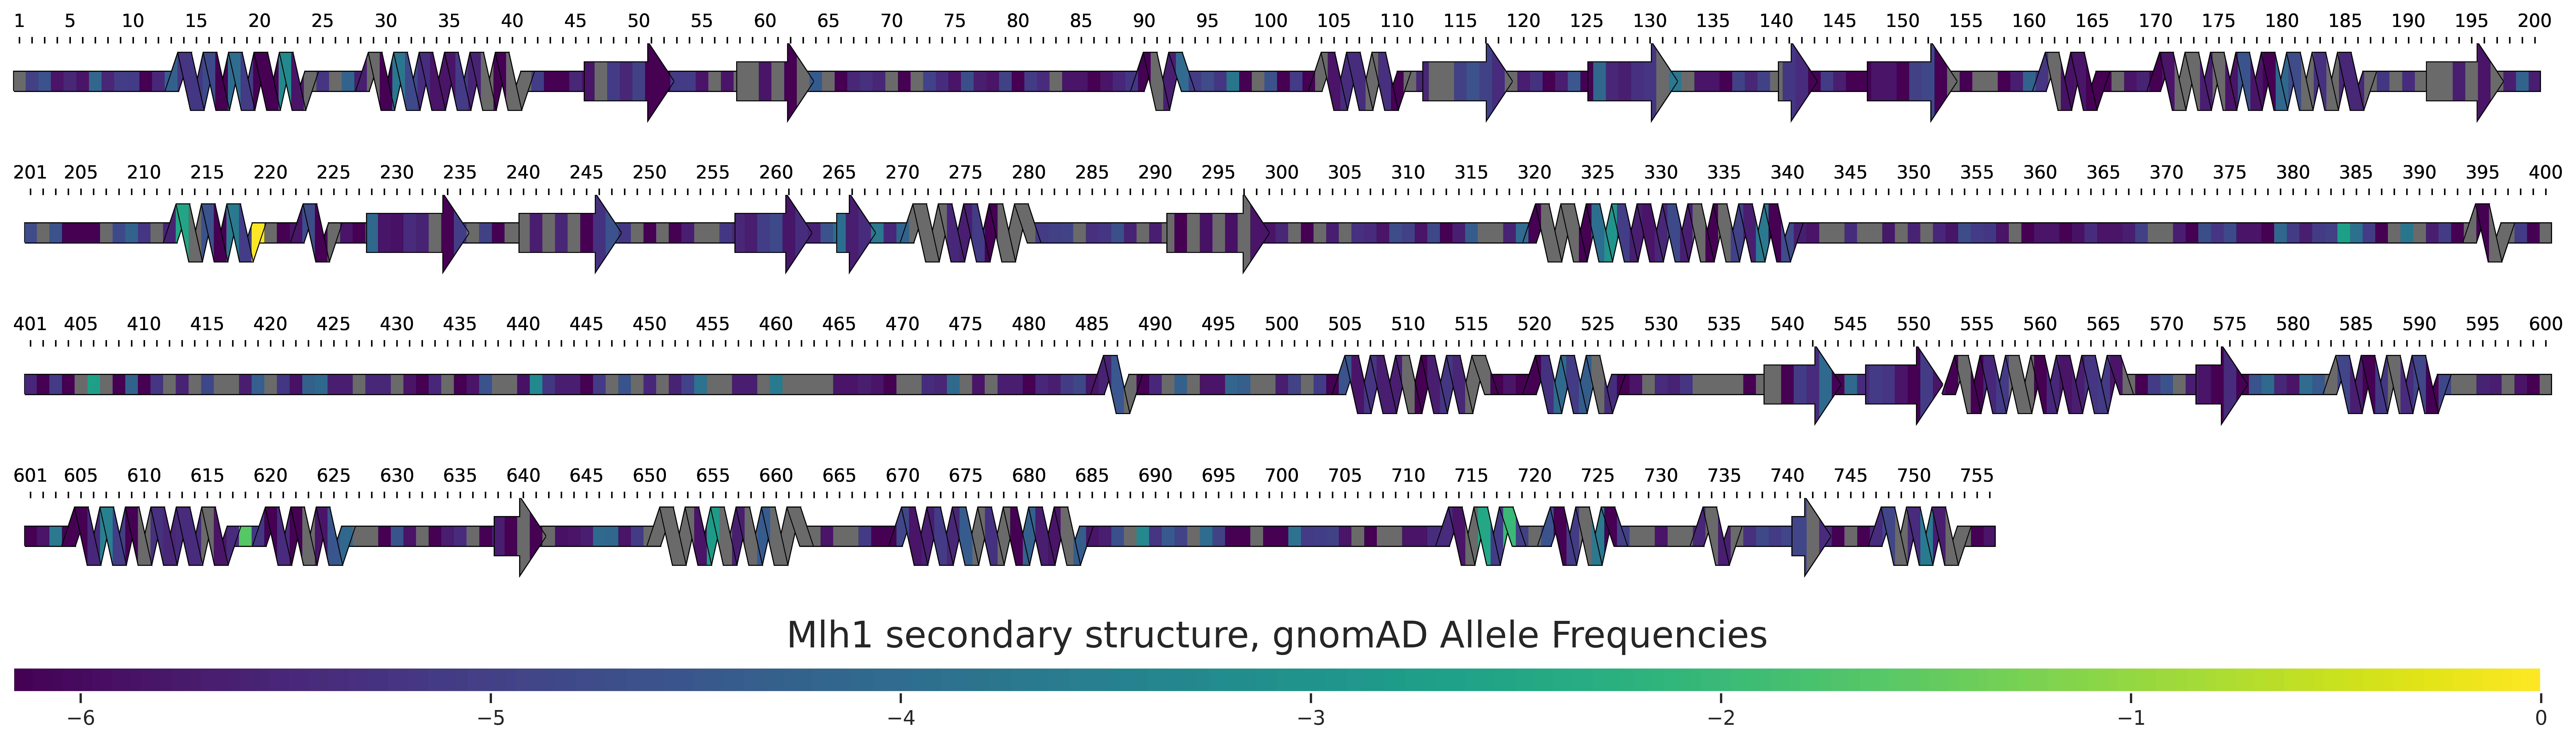

In [17]:
#@title Run SSDraw to get secondary structure scheme
#%%capture

#@markdown The output (individual PNGs per region, one PNG for the whole sequence,
#@markdown and a PDB file with allele frequencies mapped to the b-factor column)
#@markdown is located in the UNIPROT_ID/output folder.

#@markdown The color scale uses min and max for the entire protein sequence
#@markdown even if only certain regions are selected.

#@markdown NaNs (positions where there is no reported population variants)
#@markdown are marked in grey.

color_map = 'viridis'#@param {type:"string"}
#color_map = color_map.split(' ')

option_list = ['python3', 'dependencies/gnomADxSSDraw/SSDraw/SSDraw.py',
                         '--fasta', fasta_path, '--name', uniprot_id,
                        '--pdb', new_pdb_path,
                         '-bfactor', '--ticks', str(tick_loc)]
# , '--dpi', '300'
region_list = list()
if regions_to_plot != 'custom regions':
  if regions_to_plot == 'default':
    slice_len = 200
    l_max = 200
  elif regions_to_plot == 'custom slice length':
    slice_len = int(slice_len)
    l_max=int(slice_len)

  png_n = int(len(uniprot_sequence)/slice_len)
  for n in range(png_n+1):
      if n != png_n:
          s_e = (slice_len*n, slice_len*(n+1)-1)
      else:
          s_e = (slice_len*n, len(uniprot_sequence)-1)
      region_list.append(s_e)
else:
  region_sets = regions.split(',')
  l_max=0
  for r_set in region_sets:
    region_s_e = r_set.split('-')
    s_e = (int(region_s_e[0])-1, int(region_s_e[1])-1)
    region_list.append(s_e)
    if l_max<(s_e[1] - s_e[0]):
      l_max = s_e[1] - s_e[0] + 1

png_list = list()
for region in region_list:
    png_name = os.path.join(main, uniprot_id, 'output',
                            f'{uniprot_id}_{str(region[0]+1)}_{str(region[1]+1)}')
    png_list.append(png_name+'.png')
    option_list_reg = option_list.copy()
    option_list_reg.append('--start')
    option_list_reg.append(str(region[0]))
    option_list_reg.append('--end')
    option_list_reg.append(str(region[1]))
    option_list_reg.append('--output')
    option_list_reg.append(png_name)
    option_list_reg.append('--color_map')
    option_list_reg.extend(color_map.split())
    # for color in color_map:
    #   option_list_reg.append(color)
    result = subprocess.run(option_list_reg,
                            cwd='.',
                            capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Error: {result.stderr}")
    else:
        print(f"Command executed successfully: {result.stdout}")

from PIL import Image

if score_type == 'gnomAD Allele Frequency':
  fig = make_colorbar(color_map, np.nanmin(AF_list), 0,
                      fig_name=fig_name, l=l_max/8)
elif score_type == 'custom score':
  # fig = make_colorbar(color_map, np.nanmin(AF_list), np.nanmax(AF_list),
  #                     fig_name=fig_name, l=l_max/8)
  fig = make_colorbar(color_map, -np.nanmax(AF_list), np.nanmax(AF_list),
                      fig_name=fig_name, l=l_max/8)
plt.close(fig)
cbar_path = os.path.join(main, uniprot_id, 'output',
                'colorbar_SSDraw.png')
fig.savefig(cbar_path, format='png', dpi=600, bbox_inches='tight')

# List of image file paths
png_list.append(cbar_path)

# Open all images and find the total height and max width
images = [Image.open(png) for png in png_list]
widths, heights = zip(*(img.size for img in images))

# Calculate the total height and max width for the final stacked image
total_height = sum(heights)
max_width = max(widths)

# if score_type == 'AF':
#   fig = make_colorbar(color_map, np.nanmin(AF_list), 0,
#                       fig_name=fig_name, l=max_width)
# elif score_type == 'custom score':
#   fig = make_colorbar(color_map, np.nanmin(AF_list), np.nanmax(AF_list),
#                       fig_name=fig_name, l=max_width)
# plt.close(fig)
# cbar_path = os.path.join(main, uniprot_id, 'output',
#                 'colorbar_SSDraw.png')
# fig.savefig(cbar_path, format='png', dpi=600, bbox_inches='tight')

# Create a new blank image with the combined dimensions
combined_image = Image.new('RGB', (max_width, total_height), color='white')

# Paste each image into the new image, one below the other
y_offset = 0
for img in images:
    combined_image.paste(img, (0, y_offset))
    y_offset += img.height

# Save the result
# combined_image.save(os.path.join(main, uniprot_id, 'output',
#                             f'{uniprot_id}_SSDraw_stacked.png'))

combined_image.save(os.path.join(main, uniprot_id, 'output',
                            f'{uniprot_id}_SSDraw_stacked.pdf'), format='pdf')

# Display the final merged image in Colab
display(combined_image)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

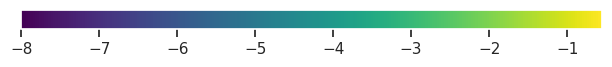

In [56]:
#@title py3Dmol visualization
#%%capture

#@markdown 3D visualization of the structure with Allele Frequencies mapped.

#@markdown Unlike the secondary sructure diagram, this one uses -8 as a value
#@markdown for positions without reported variants.

import matplotlib.colors as mcolors
import py3Dmol

# Number of colors to sample from the colormap
num_colors = 256  # you can adjust this number based on your needs

# Retrieve the colors in the 'inferno' colormap and convert them to hex format
# cmap_obj = plt.cm.get_cmap(color_map, num_colors)
cmap_obj = plt.colormaps.get_cmap(color_map)
hex_colors = [mcolors.rgb2hex(cmap_obj(i)) for i in range(num_colors)]

# Load a local PDB file
with open(new_pdb_path_3d, 'r') as f:
    pdb_data = f.read()

view = py3Dmol.view(width=600, height=600)
# Load PDB data into the viewer
view.addModel(pdb_data, 'pdb')
# Apply cartoon style with color spectrum
#view.setStyle({'cartoon': {'color': 'spectrum'}})
view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'linear',
                                           'min':np.nanmin(AF_list_3d),
                                           'max':np.nanmax(AF_list_3d),
                                           'colors':hex_colors}}})
#view.setStyle({'cartoon': {}})
#view.setColorByProperty({'cartoon': {}}, 'b')  # Color by B-factors ('b')
#view.zoomTo()  # Zoom to fit the structure
view.show()  # Display the structure

fig = make_colorbar(color_map, np.nanmin(AF_list_3d), np.nanmax(AF_list_3d), l=7.5)

In [63]:
#@title Download the output folder
#%%capture

#@markdown The output contains individual PNGs per region, one PNG for the whole
#@markdown sequence, and two PDB file with allele frequencies mapped to the
#@markdown b-factor column -- one with NaNs for position with no values,
#@markdown and one with -8 (numeric value is required to enable color mapping
#@markdown to the 3D structure).

#@markdown You should be able to visualise it with
#@markdown <spectrum b, inferno, minimum=MIN, maximum=MAX> command in PyMOL.


print('Custom PyMOL command for inferno colormap: ')
print('set_color dark_purple, [0.001, 0.000, 0.014]')
print('set_color red_orange, [0.451, 0.000, 0.004]')
print('set_color orange_yellow, [0.859, 0.278, 0.172]')
print('set_color bright_yellow, [0.988, 0.998, 0.645]')
print(f'spectrum b, dark_purple red_orange orange_yellow \
bright_yellow, minimum={np.nanmin(AF_list_3d)}, maximum={np.nanmax(AF_list_3d)}')
gap = abs(np.nanmax(AF_list_3d)-np.nanmin(AF_list_3d))/3
print(f'ramp_new inferno_ramp, {uniprot_id}_bfact_3d,\
 [{np.nanmin(AF_list_3d)}, {np.nanmax(AF_list_3d)-2*gap}, {np.nanmax(AF_list_3d)-gap},{np.nanmax(AF_list_3d)}],\
  [dark_purple, red_orange, orange_yellow, bright_yellow]')

import shutil
from google.colab import files

# Path to the directory you want to zip (replace with your directory path)
dir_to_zip = os.path.join(main, uniprot_id, 'output')

# Name of the output zip file
zip_filename = f'gnomADxSSDraw_{uniprot_id}.zip'

# Zip the directory
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', dir_to_zip)

# Download the zip file
files.download(zip_filename)

Custom PyMOL command for inferno colormap: 
set_color dark_purple, [0.001, 0.000, 0.014]
set_color red_orange, [0.451, 0.000, 0.004]
set_color orange_yellow, [0.859, 0.278, 0.172]
set_color bright_yellow, [0.988, 0.998, 0.645]
spectrum b, dark_purple red_orange orange_yellow bright_yellow, minimum=-8.0, maximum=-0.5466272858526676
ramp_new inferno_ramp, P40692_bfact_3d, [-8.0, -5.515542428617556, -3.0310848572351117,-0.5466272858526676],  [dark_purple, red_orange, orange_yellow, bright_yellow]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>